<a href="https://colab.research.google.com/github/vKrRv/porta-trucks-detector/blob/plate/license-plate-detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Porta 🚛
### License Plates Detector and Classifier

## Setup

### Dependecies Operations

In [ ]:
from IPython.display import clear_output

> #### **Run this cell only once! After restart ignore it**

In [ ]:
# Install dependencies
!pip uninstall -y langchain
!pip uninstall -y paddleocr paddlepaddle
!pip install ultralytics
# # Uncomment based on running enviroment (cpu vs gpu)
# !pip install paddlepaddle # CPU Version
# !pip install paddlepaddle-gpu # GPU Version
!pip install paddleocr
!pip install opencv-python
!pip install matplotlib
!pip install langchain==0.0.354

clear_output()

In [ ]:
# Import libraries
import os
import kagglehub
import cv2
import paddle
import glob
import shutil

import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from paddleocr import PaddleOCR

clear_output()

In [ ]:
# Initialize OCR engine once (it's heavy) to save time later
ocr = PaddleOCR(lang='en', use_angle_cls=True)

clear_output()

/tmp/ipython-input-3845855397.py:2: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(lang='en', use_angle_cls=True)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.


AttributeError: 'paddle.base.libpaddle.AnalysisConfig' object has no attribute 'set_optimization_level'

### Dataset Operations

In [ ]:
# Download the dataset
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")
print("Dataset downloaded to:", path)

# Check what's inside
print("Contents:", os.listdir(path))

Using Colab cache for faster access to the 'car-plate-detection' dataset.
Dataset downloaded to: /kaggle/input/car-plate-detection
Contents: ['annotations', 'images']


In [ ]:
# Define paths to images and labels
images_path = os.path.join(path, 'images')
labels_path = os.path.join(path, 'annotations')

print("Images path:", images_path)
print("Labels path:", labels_path)

Images path: /kaggle/input/car-plate-detection/images
Labels path: /kaggle/input/car-plate-detection/annotations


In [ ]:
# Create directories in a writable location
# The original dataset path '/kaggle/input/car-plate-detection' is read-only.
# We need to create our working directories in a writable location like '/kaggle/working/'.
base_output_dir = '/kaggle/working/car-plate-detection-processed' # A new writable directory

# Define new paths for processed images and labels
# These paths will be used to store the train/validation splits.
processed_images_path = os.path.join(base_output_dir, 'images')
processed_labels_path = os.path.join(base_output_dir, 'labels')

# Create the necessary subdirectories
os.makedirs(os.path.join(processed_images_path, "train"), exist_ok=True)
os.makedirs(os.path.join(processed_images_path, "val"), exist_ok=True)
os.makedirs(os.path.join(processed_labels_path, "train"), exist_ok=True)
os.makedirs(os.path.join(processed_labels_path, "val"), exist_ok=True)

print(f"Train and validation directories created in: {base_output_dir}")

Train and validation directories created in: /kaggle/working/car-plate-detection-processed


#### Train-Test Split

In [ ]:
# Helper function: Convert XML bounds to YOLO normalized bounds
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

In [ ]:
# Get list of all images in the downloaded path
image_files = glob.glob(os.path.join(path, "images", "*.png"))

# Split into Train (80%) and Validation (20%)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

In [ ]:
def process_files(files_list, split_name):
    print(f"Processing {len(files_list)} files for {split_name}...")

    for img_file in files_list:
        filename = os.path.basename(img_file)
        file_id = os.path.splitext(filename)[0]

        # 1. Copy Image to the processed images path
        shutil.copy(img_file, os.path.join(processed_images_path, split_name, filename))

        # 2. Parse XML (Annotation)
        xml_file = os.path.join(path, "annotations", file_id + ".xml")
        if not os.path.exists(xml_file): continue

        tree = ET.parse(xml_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        yolo_lines = []
        for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls == "licence": # The class name in this dataset is 'licence'
                xmlbox = obj.find('bndbox')
                b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                     float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
                bb = convert_bbox((w, h), b)
                # YOLO format: class_id center_x center_y width height
                # We use class_id '0' for license plate
                yolo_lines.append(f"0 {bb[0]} {bb[1]} {bb[2]} {bb[3]}")

        # 3. Save TXT label to the processed labels path
        txt_filename = file_id + ".txt"
        with open(os.path.join(processed_labels_path, split_name, txt_filename), 'w') as f:
            f.write('\n'.join(yolo_lines))

In [ ]:
# Run the conversion
process_files(train_files, "train")
process_files(val_files, "val")
print("Conversion Complete! Data is ready in 'datasets/plate_data'")

Processing 346 files for train...
Processing 87 files for val...
Conversion Complete! Data is ready in 'datasets/plate_data'


> #### YOLO `data.yaml` confg file

In [ ]:
yaml_content = f"""
path: {os.path.abspath(base_output_dir)}
train: images/train
val: images/val

nc: 1
names: ['license_plate']
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created!")

data.yaml created!


## Train

In [ ]:
# Load a pre-trained nano model (fastest)
model = YOLO('yolov8n.pt')

In [ ]:
# Train it on your dataset
results = model.train(
    data='data.yaml',
    epochs=5,
    imgsz=640,
    batch=16,
    project='plate_detector', # saves the results in a folder named 'plate_detector'
    name='train_run'
)

Ultralytics 8.4.13 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (AMD EPYC 7B13)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

👀 Viewing results from: /content/runs/detect/plate_detector/train_run2

--- GROUND TRUTH (Actual Labels) ---


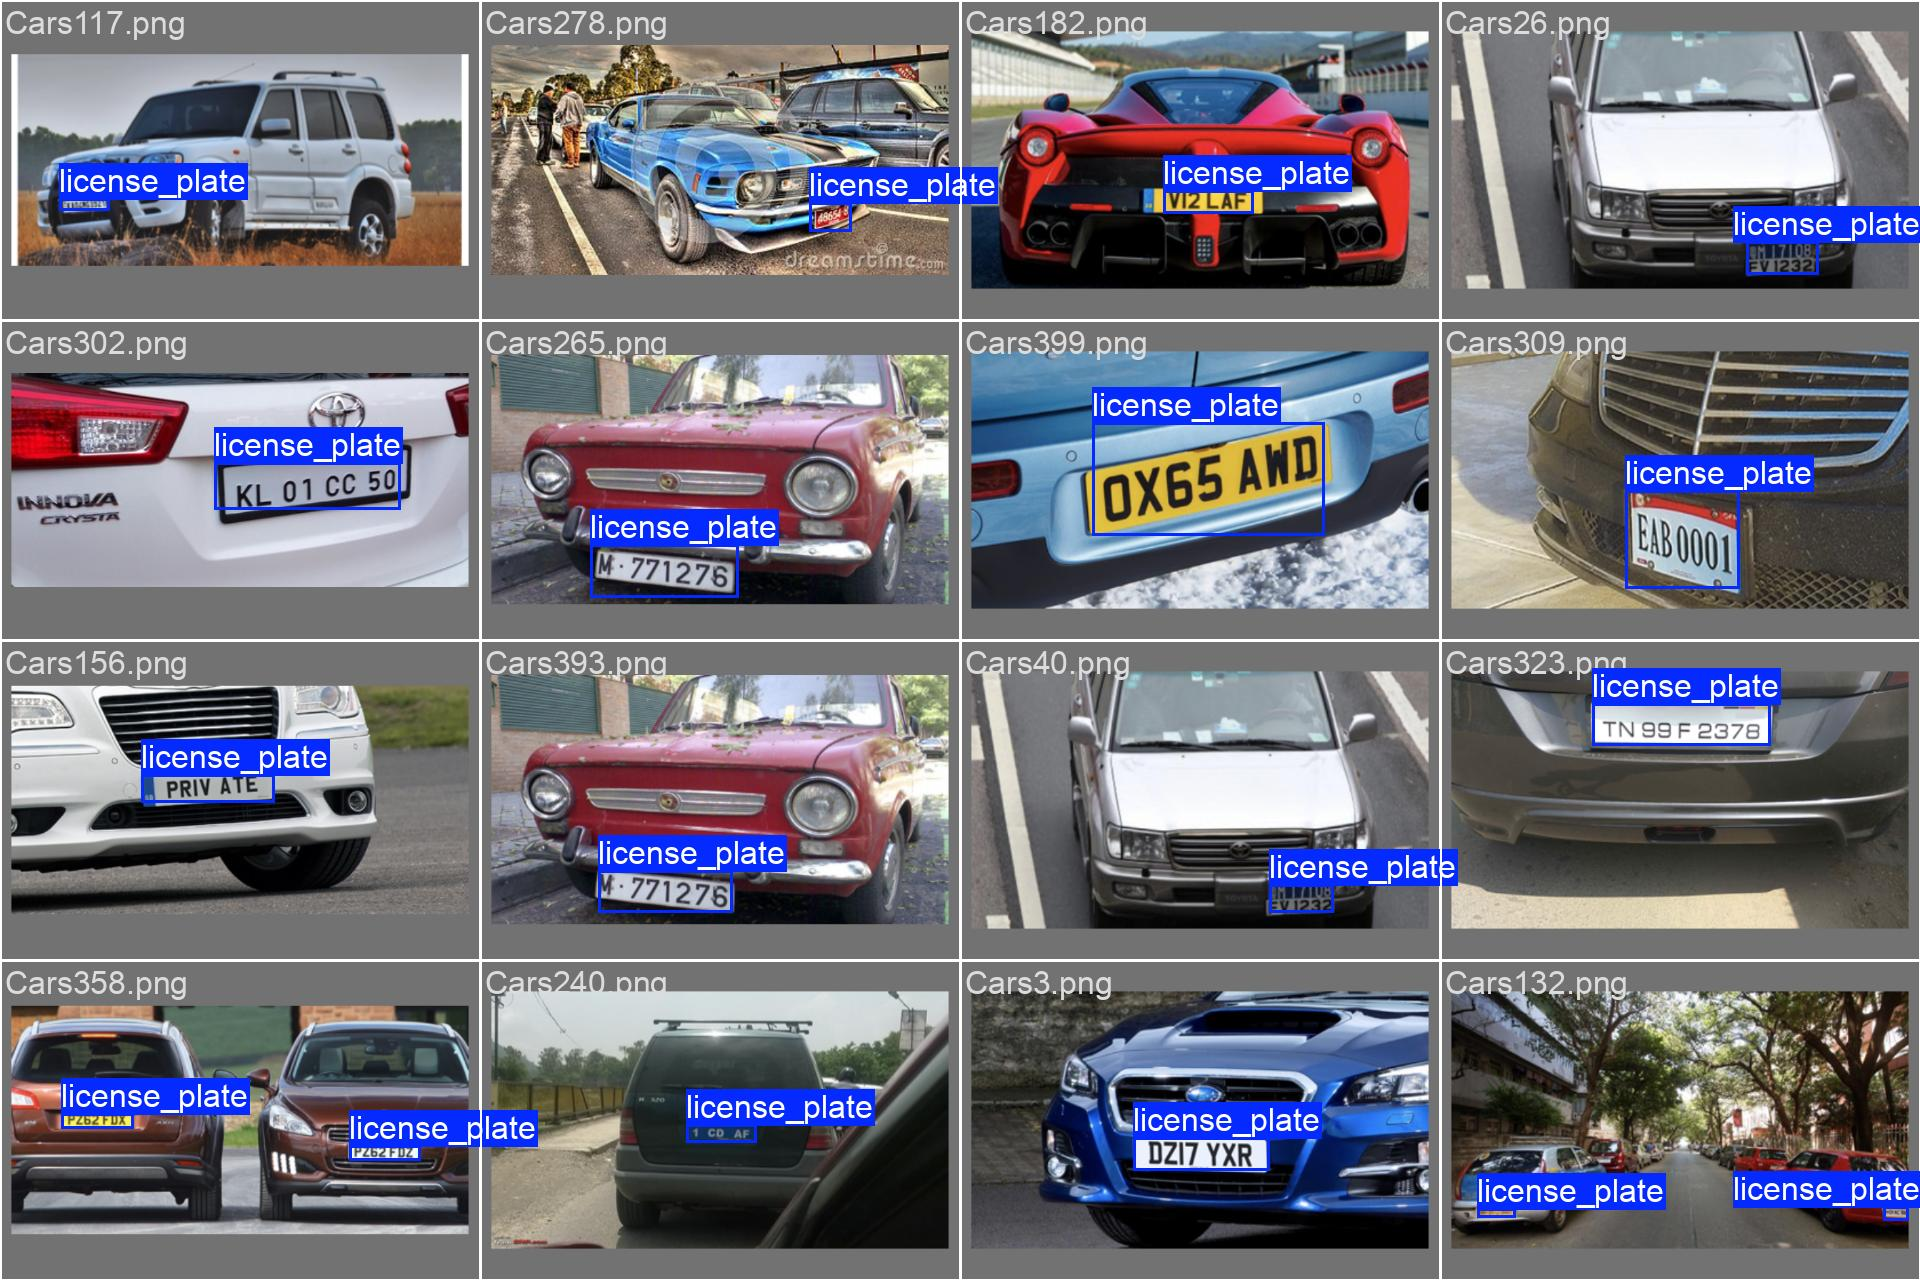


--- MODEL PREDICTIONS (What it detected) ---


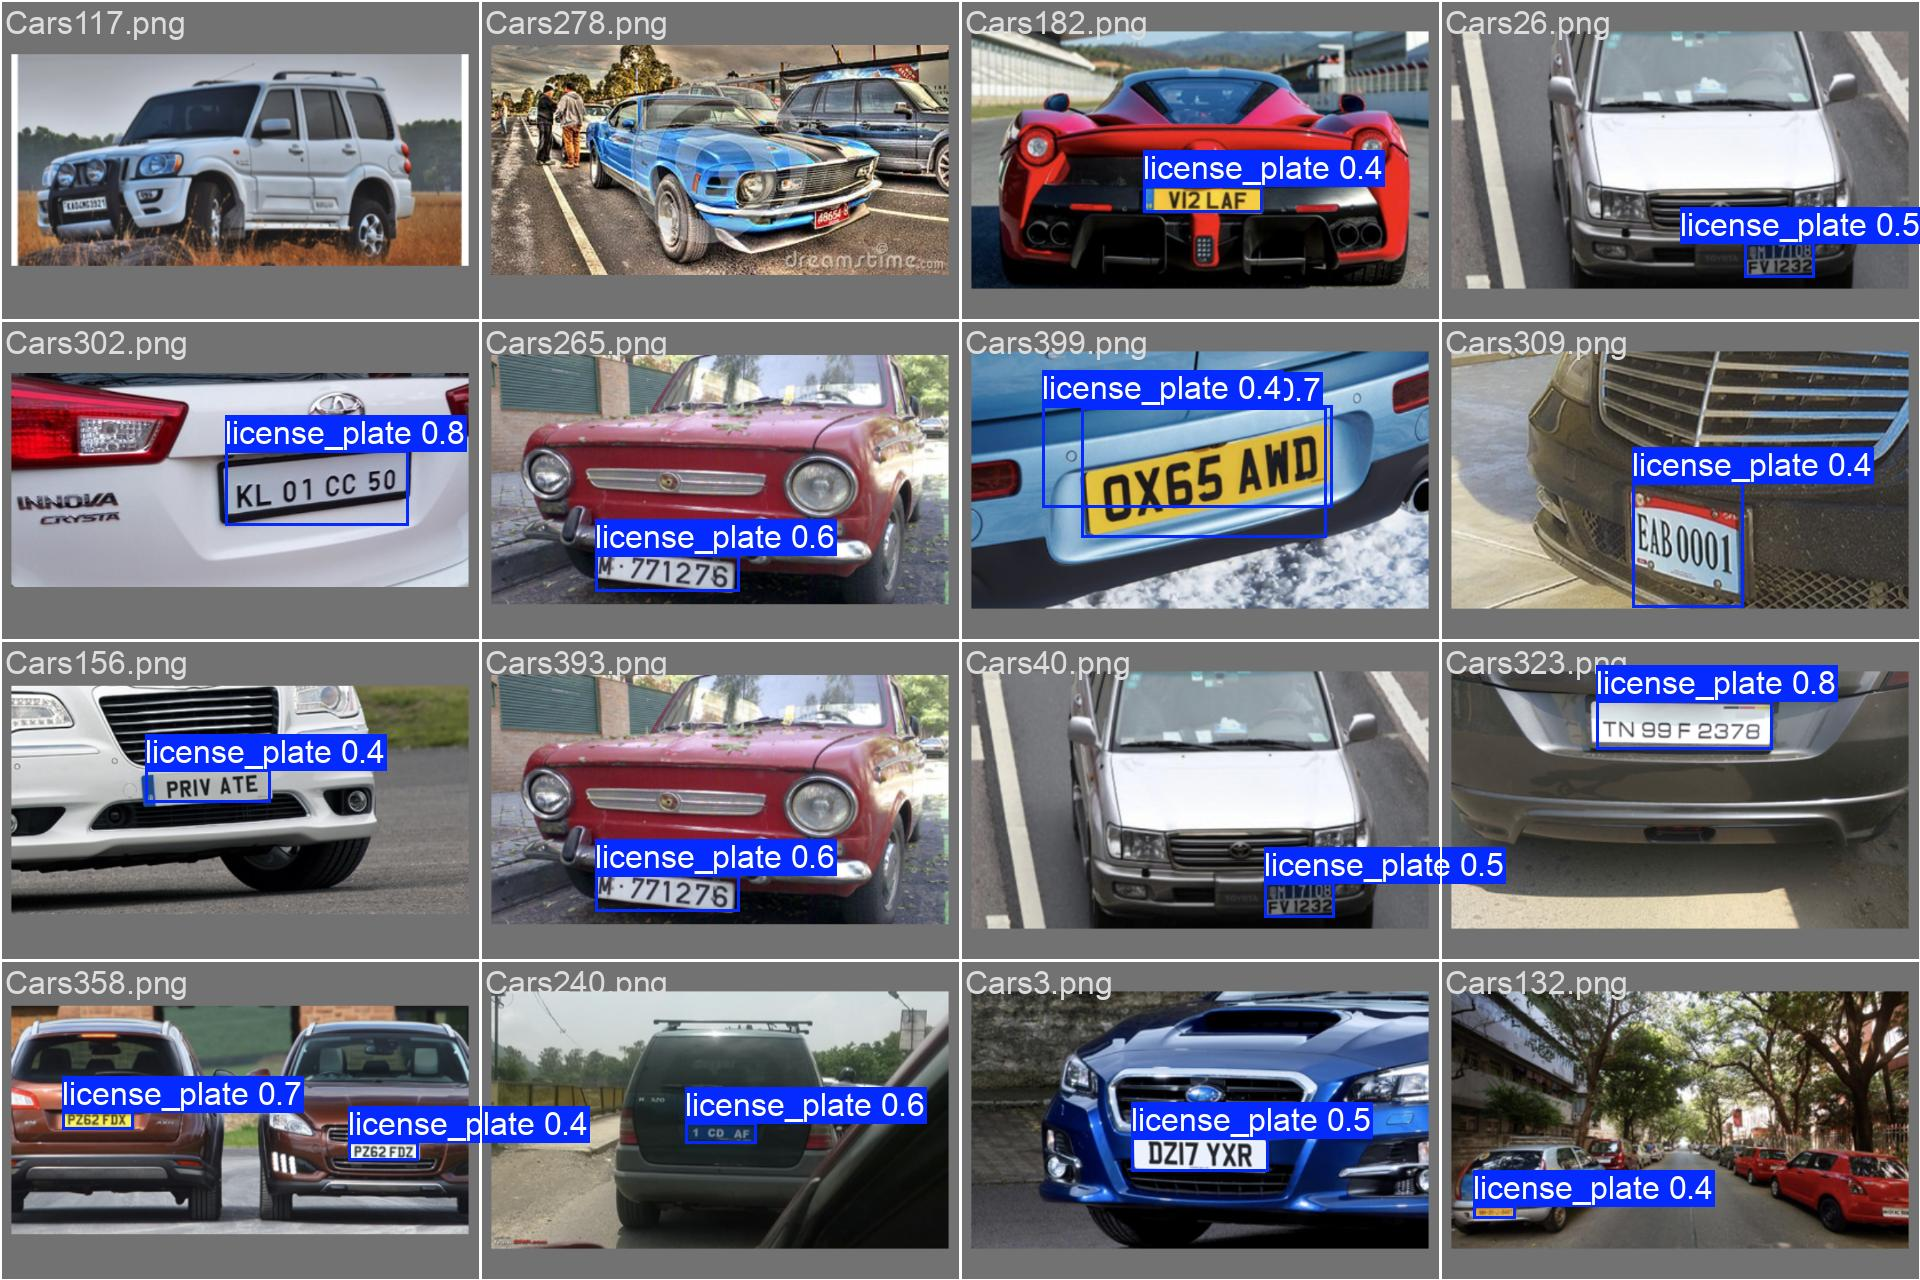

In [ ]:
import os
import glob
from IPython.display import Image, display

# 1. Find the latest training folder automatically
# Your logs show it's likely 'train_run2', but this script finds the newest one always.
# Note: In Colab, the root folder for runs is often '/content/runs/...'
base_path = '/content/runs/detect/plate_detector'
list_of_runs = glob.glob(os.path.join(base_path, '*'))
latest_run = max(list_of_runs, key=os.path.getmtime)

print(f"👀 Viewing results from: {latest_run}")

# 2. Display Ground Truth (What the answer SHOULD be)
print("\n--- GROUND TRUTH (Actual Labels) ---")
label_img_path = os.path.join(latest_run, 'val_batch0_labels.jpg')
if os.path.exists(label_img_path):
    display(Image(filename=label_img_path, width=800))
else:
    print("⚠️ Labels image not found.")

# 3. Display Predictions (What your AI saw)
print("\n--- MODEL PREDICTIONS (What it detected) ---")
pred_img_path = os.path.join(latest_run, 'val_batch0_pred.jpg')
if os.path.exists(pred_img_path):
    display(Image(filename=pred_img_path, width=800))
else:
    print("⚠️ Prediction image not found.")

## Define Logic

## Run Pipline